<a href="https://colab.research.google.com/github/AliAkbarBadri/pokemon-gan/blob/master/mlp-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageOps
import glob
import time
import matplotlib.gridspec as gridspec
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Data

## JPG

In [ ]:
! mkdir "./data"

In [ ]:
from PIL import Image
import glob
data_dir = "/content/drive/My Drive/nn/gan/data"

for file in glob.glob(data_dir + '/*.png'):
    img = Image.open(file)
    jpg = img.convert('RGB')
    jpg.save('./data/' + file.split('/')[-1].split('.')[0] + '.jpg')

In [ ]:
! ls "/content/drive/My Drive/nn/gan/data_jpg/0/"

0.jpg	 155.jpg  226.jpg  27.jpg   333.jpg  376.jpg  420.jpg  468.jpg	5.jpg
100.jpg  158.jpg  227.jpg  280.jpg  334.jpg  377.jpg  422.jpg  469.jpg	61.jpg
101.jpg  159.jpg  228.jpg  282.jpg  336.jpg  378.jpg  423.jpg  46.jpg	63.jpg
103.jpg  15.jpg   229.jpg  283.jpg  337.jpg  379.jpg  424.jpg  470.jpg	64.jpg
104.jpg  160.jpg  22.jpg   284.jpg  338.jpg  37.jpg   425.jpg  471.jpg	65.jpg
105.jpg  161.jpg  232.jpg  285.jpg  339.jpg  380.jpg  426.jpg  474.jpg	66.jpg
109.jpg  162.jpg  235.jpg  289.jpg  340.jpg  381.jpg  428.jpg  475.jpg	67.jpg
10.jpg	 163.jpg  236.jpg  28.jpg   341.jpg  382.jpg  42.jpg   476.jpg	68.jpg
110.jpg  16.jpg   237.jpg  290.jpg  342.jpg  384.jpg  430.jpg  477.jpg	69.jpg
111.jpg  170.jpg  239.jpg  293.jpg  343.jpg  385.jpg  431.jpg  479.jpg	70.jpg
113.jpg  171.jpg  23.jpg   294.jpg  344.jpg  386.jpg  432.jpg  47.jpg	71.jpg
114.jpg  173.jpg  240.jpg  296.jpg  345.jpg  387.jpg  434.jpg  480.jpg	73.jpg
115.jpg  174.jpg  241.jpg  298.jpg  346.jpg  388.jpg  436.jpg  481.jpg

## Load

In [3]:
def load_data(image_shape, batch_size):
    image_data_generator = ImageDataGenerator()
    dataset_path = "/content/drive/My Drive/nn/gan/data_jpg/"
    dataset_generator = image_data_generator.flow_from_directory(
        dataset_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size,
        class_mode=None)
    return dataset_generator

In [4]:
! mkdir "./new_images"

In [5]:
def save_images(generated_images, epoch_no, batch_no):
    plt.figure(figsize=(8, 8), num=2)
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0, hspace=0)
    # print("Shape",generated_images.shape)
    for i in range(32):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i, :, :, :]
        image += 1
        image *= 127.5
        fig = plt.imshow(image.numpy().astype(np.uint8))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    save_name = 'new_images/generated_epoch' + str(
        epoch_no + 1) + '_batch' + str(batch_no + 1) + '.png'
    if not os.path.exists('new_images'):
        os.mkdir('new_images')
    plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.pause(0.0000000001)
    plt.show()

# Model (MLP-CNN)

In [31]:
def get_generator(codings_size=100):
        generator = Sequential(name="GEN_MODEL")
        generator.add(Dense(units=4 * 4 * 512,
                            kernel_initializer='glorot_uniform',
                            input_shape=[100], name="Dense1"))
        generator.add(Reshape(target_shape=(4, 4, 512),name="Reshape1"))
        generator.add(BatchNormalization(momentum=0.5,name="BN1"))
        generator.add(Activation('relu',name="relu1"))

        generator.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform',
                                      name="C2DT2"))
        generator.add(BatchNormalization(momentum=0.5,name="BN2"))
        generator.add(Activation('relu',name="relu2"))

        generator.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform',
                                      name="C2DT3"))
        generator.add(BatchNormalization(momentum=0.5,name="BN3"))
        generator.add(Activation('relu',name="relu3"))

        generator.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform',
                                      name="C2DT4"))
        generator.add(BatchNormalization(momentum=0.5,name="BN4"))
        generator.add(Activation('relu',name="relu4"))

        generator.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform',
                                      name="C2DT5"))
        
        generator.add(Activation('tanh',name="tanh"))
        optimizer = Adam(lr=0.00015, beta_1=0.5)
        generator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

        return generator

# def get_discriminator(image_shape):
#     discriminator = keras.models.Sequential([
#       keras.layers.Flatten(input_shape=image_shape,name="dis_flatten"),
#       keras.layers.Dense(1024, activation="selu",name="dis_dense1"),
#       # keras.layers.Dense(100, activation="selu",name="dis_dense2"),
#       keras.layers.Dense(1, activation="sigmoid",name="dis_dense3")
#     ],name = "DISC_MODEL")
#     # discriminator.
#     # optimizer = Adam(lr=0.0002, beta_1=0.5)
#     discriminator.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
#     return discriminator
def get_discriminator(image_shape):
    discriminator = keras.models.Sequential([
      keras.layers.Flatten(input_shape=image_shape,name="dis_flatten"),
      keras.layers.Dense(256, name="dis_dense1"),
      keras.layers.LeakyReLU(alpha=0.2),
      keras.layers.Dense(1, activation="sigmoid",name="dis_dense3")
    ],name = "DISC_MODEL")
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
    return discriminator

def get_adversarial(generator, discriminator):
    gan = Sequential()
    discriminator.trainable = False
    gan.add(generator)
    gan.add(discriminator)

    # optimizer = Adam(lr=0.00015, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer="adam",
                metrics=None)
    return gan

# Train

In [24]:
def train(epochs, batch_size, image_shape,number_of_batches=11):
    generator = get_generator(image_shape)
    generator.summary()
    discriminator = get_discriminator(image_shape)
    discriminator.summary()
    gan = get_adversarial(generator, discriminator)

    # Load dataset
    dataset_generator = load_data(image_shape, batch_size)

    # Variables that will be used to plot the losses from the discriminator and
    # the adversarial models
    batches = np.empty(shape=1)

    # Allow plot updates inside for loop
    plt.ion()

    current_batch = 0

    # Begin training
    g_loss_all = []
    d_loss_all = []
    d_acc_all = []
    for epoch in range(epochs):
        g_loss_batch = []
        d_loss_batch = []
        d_acc_batch = []
        start_time = time.time()
        for batch_number in range(number_of_batches):
            real_images = dataset_generator.next()

            # Normalize the images between -1 and 1
            real_images /= 127.5
            real_images -= 1
            # The last batch is smaller than the other ones, so we need to
            # take that into account
            current_batch_size = real_images.shape[0]
            # Generate noise
            noise = np.random.normal(0, 1,
                                      size=(current_batch_size,) + (1, 1, 100)).reshape(current_batch_size,100)
            # Generate images
            generated_images = generator(noise)

            # Add some noise to the labels that will be fed to the discriminator
            # real_y = (np.ones(current_batch_size) -
            #           np.random.random_sample(current_batch_size) * 0.2)
            # fake_y = np.random.random_sample(current_batch_size) * 0.2

            real_y = np.ones(current_batch_size)
            fake_y = np.zeros(current_batch_size)

            # Let's train the discriminator
            discriminator.trainable = True

            d_loss_real = discriminator.train_on_batch(real_images, real_y)
            d_loss_fake = discriminator.train_on_batch(generated_images, fake_y)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_loss_batch.append(d_loss[0])
            d_acc_batch.append(d_loss[1])

            # Now it's time to train the generator
            discriminator.trainable = False
            noise = np.random.normal(0, 1,
                                      size=(current_batch_size * 2,) +
                                          (1, 1, 100)).reshape(current_batch_size * 2,100)

            # We try to mislead the discriminator by giving the opposite labels
            # fake_y = (np.ones(current_batch_size * 2) -
            #           np.random.random_sample(current_batch_size * 2) * 0.2)
            fake_y = np.ones(current_batch_size * 2) 
            g_loss = gan.train_on_batch(noise, fake_y)
            g_loss_batch.append(g_loss)

            # Each 32 batches show and save images
            # if epoch%30==0 and batch_number + 1 == 11:
                # save_images(generated_images, epoch, batch_number)
            current_batch += 1
        time_elapsed = time.time() - start_time
        if epoch%5==0:
          print("epoch: "+str(epoch+1)+", generator loss: "+str(np.mean(g_loss_batch))
                  + ", discriminator loss: " + str(np.mean(d_loss_batch))
                  + ", discriminator acc: " + str(np.mean(d_acc_batch)) 
                  + ', epoch took ' + str(time_elapsed) + ' s.')
        g_loss_all.append(np.mean(g_loss_batch))
        d_loss_all.append(np.mean(d_loss_batch))
        d_acc_all.append(np.mean(d_acc_batch))
    generator.save('generator_mlp.h5')
    discriminator.save('discriminator_mlp.h5')        
    return g_loss_all, d_loss_all, d_acc_all

In [32]:
data_size = 352
batch_size = 32
image_shape = (64, 64,3)
coding_size = 100 
epochs = 101
g_loss_all, d_loss_all, d_acc_all = train(epochs, batch_size, image_shape)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 8192)              827392    
_________________________________________________________________
Reshape1 (Reshape)           (None, 4, 4, 512)         0         
_________________________________________________________________
BN1 (BatchNormalization)     (None, 4, 4, 512)         2048      
_________________________________________________________________
relu1 (Activation)           (None, 4, 4, 512)         0         
_________________________________________________________________
C2DT2 (Conv2DTranspose)      (None, 8, 8, 256)         3277056   
_________________________________________________________________
BN2 (BatchNormalization)     (None, 8, 8, 256)         1024      
_________________________________________________________________
relu2 (Activation)           (None, 8, 8, 256)       

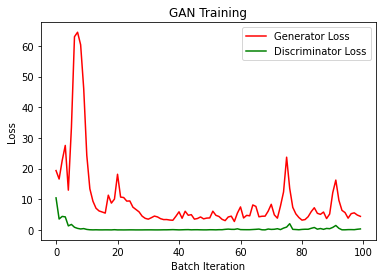

In [33]:
plt.figure(1)
plt.plot(range(epochs), g_loss_all, color='red',
          label='Generator Loss')
plt.plot(range(epochs), d_loss_all, color='green',
          label='Discriminator Loss')
plt.title("GAN Training")
plt.xlabel("Batch Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

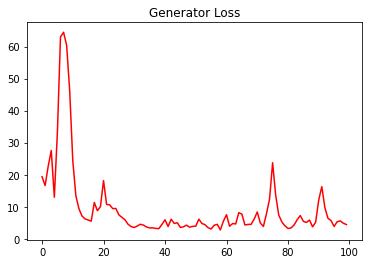

In [34]:
plt.plot(range(epochs), g_loss_all, color='red')
plt.title("Generator Loss")
plt.show()

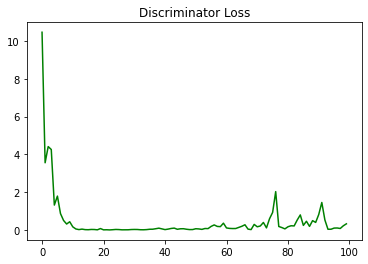

In [35]:
plt.plot(range(epochs), d_loss_all, color='green')
plt.title("Discriminator Loss")
plt.show()

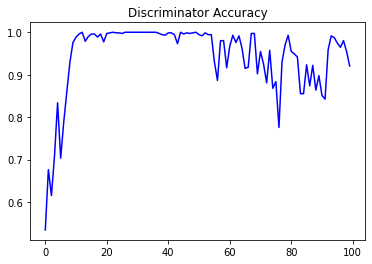

In [36]:
plt.plot(range(epochs), d_acc_all, color='blue')
plt.title("Discriminator Accuracy")
plt.show()